In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transform
import torchvision
from torch.utils.data import DataLoader, Dataset

In [ ]:
transformation = transform.Compose([
    transform.Resize((224,224)), # resnet is trained on 224x224 images
    transform.ToTensor(),
    transform.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))

])

### Downlaod the dataset

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root="/content/data",train=True,download=True,transform=transformation)
tets_dataset = torchvision.datasets.CIFAR10(root="/content/data",train=False,download=True,transform=transformation)


Files already downloaded and verified
Files already downloaded and verified


### creating train and test loader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(tets_dataset, batch_size=32,shuffle=True)

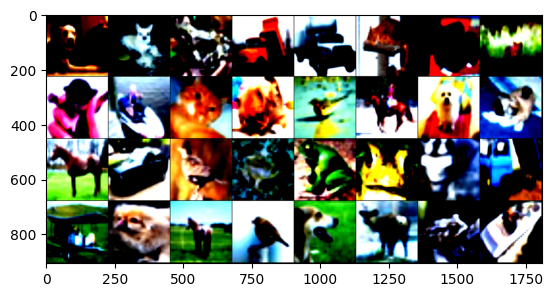

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_data = iter(train_loader)
images,labels = next(sample_data)

def imshow(img):
  img_arr = img.numpy()
  plt.imshow(np.transpose(img_arr,(1,2,0)))
  plt.show()

imshow(torchvision.utils.make_grid(images))

### Downlaod the Resnet model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Before we do transfer learning freeze the feature layers


In [ ]:
for params in resnet18.parameters():
  params.required_grad = False

In [ ]:
resnet18.fc = nn.Linear(resnet18.fc.in_features,10)

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18=resnet18.to("cuda")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.fc.parameters(),lr=0.001)

In [ ]:
resnet18.train()

for epoch in range(0,10): #run the epoch minimum 50
  total_loss=0
  for images, labels in train_loader:
    images=images.to("cuda")
    labels=labels.to("cuda")

    output_ = resnet18(images) #originally resnet18 was trainign in 3.5 days

    loss= criterion(output_,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss = total_loss+loss.item()
  print(f"For {epoch} Loss is : {loss}")


For 0 Loss is : 1.4576120376586914


KeyboardInterrupt: 

### checking model performance on test data

In [ ]:
correct =0
total =0
resnet18.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    test_output = resnet18(images)
    predicted = torch.argmax(test_output,dim=1)
    total = total+labels.size(0)
    correct = correct + (predicted==labels).sum().item()

In [ ]:
print(f"The accuracy of the model is {correct/total*100}")